n_sim = 1
Idle_RU: 0.2153854755986601
success_RU: 0.21782535543457818
collision_RU: 0.5667891689667618
access_STA: 0.023127916552292068
success_STA: 0.08182559168824159
collision_STA: 0.9145575706949611
Avg_Th: 0.014034988772008983
Total_Th: 11.227991017607186
Fairness: 0.4738879238854366
Avg_Delay1: nan
Avg_Delay2: nan
Th_per_STA: array shape=(800,)
R1: array shape=(67, 2)


C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_47660\4038182824.py:603: RuntimeWarning: divide by zero encountered in divide
  Avg_Delay1 = float(np.mean(Sim_Rst[:,3] / Sim_Rst[:,1]))  # TF count 평균
C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_47660\4038182824.py:603: RuntimeWarning: invalid value encountered in divide
  Avg_Delay1 = float(np.mean(Sim_Rst[:,3] / Sim_Rst[:,1]))  # TF count 평균
C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_47660\4038182824.py:616: RuntimeWarning: divide by zero encountered in divide
  Avg_Delay2 = float( np.mean( (Sim_Rst[:,3] * const_term - tail_term) / Sim_Rst[:,1] ) * U_slot * 1e3 )
c:\Conda\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


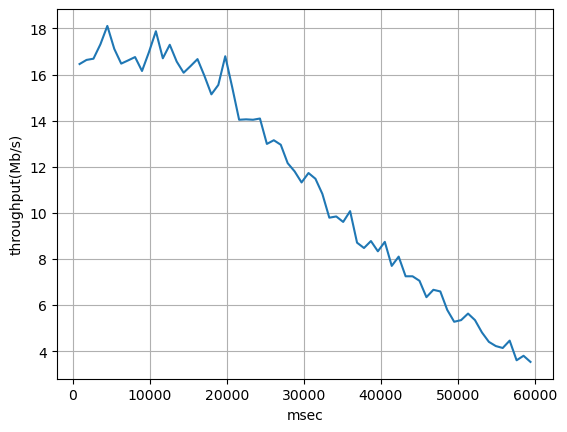

Elapsed: 5.29 sec


In [ ]:
# === RPT_Simple_UORA.py (Jupyter 단일 셀용) ===
# 원본: RPT_Simple_UORA.m (메인 시뮬레이터)
# - 로직/타이밍/난수/인덱싱을 MATLAB과 동일하게 맞춤
# - Mode_UORA=9일 때 Tab_OCW.in을 같은 폴더에서 읽습니다.
# - 분모 0에 의한 NaN/Inf가 평균으로 전파되는 것도 MATLAB과 동일 동작

import numpy as np
import math
import time
import matplotlib.pyplot as plt

# -------------------------
# 사용자 설정 (원본과 동일 파라미터 이름/의미)
# -------------------------
N_SIM = 1
List_Seed = np.arange(1731, 1731 + N_SIM)

Sim_ID = '2100518_TEST_02'

# Major parameters
OCWmin = 7    # (7 or 15)
OCWmax = 31   # (31 or 63 or 255)
Mode_UORA = 9

# pattern for unassoc. STA
N_unassoc_In  = 5   # entering to BSS each period
T_unassoc_In  = 0.0 # sec
N_unassoc_Out = 2
T_unassoc_Out = 4.0 # sec
N_STAs_Assoc  = 50  # single-case (원본은 벡터 가능하지만 여기선 1개 케이스)

Opt_Observation_TH    = 1  # per-unit_time throughput
Opt_Observation_Delay = 1
Opt_Save_Per_STA_TH   = 1

# PHY
BW   = 20  # MHz
N_ss = 1
N_bp = np.array([1,2,2,4,4,6,6,6,8,8,10,10], dtype=float) # per subcarrier
Rcod = np.array([1/2,1/2,3/4,1/2,3/4,2/3,3/4,5/6,3/4,5/6,3/4,5/6], dtype=float)
T_dft = 12.8e-6
T_gi  = 1.6e-6

# RU 구조
N_RU = 9
N_RA_RU_0    = 8  # associated STAs용 RA-RU 수
N_RA_RU_2045 = N_RU - N_RA_RU_0
Opt_Random_N_RA_RU_0 = 0

# 시뮬레이션 슬롯 수 (원본: 1111112*6)
N_slot_total = 1111112*6

# -------------------------
# 내부 함수 (원본 switch-case 등 그대로 반영)
# -------------------------

def ru_tones_by_count(N_RU):
    if N_RU == 9:
        return np.array([24]*9, dtype=float)
    elif N_RU == 8:
        return np.array([24]*7 + [48], dtype=float)
    elif N_RU == 7:
        return np.array([24]*5 + [48]*2, dtype=float)
    elif N_RU == 6:
        return np.array([24]*3 + [48]*3, dtype=float)
    elif N_RU == 5:
        return np.array([24] + [48]*4, dtype=float)
    elif N_RU == 4:
        return np.array([24]*4, dtype=float)
    elif N_RU == 2:
        return np.array([102,102], dtype=float)
    elif N_RU == 1:
        return np.array([234], dtype=float)
    else:
        raise RuntimeError('the value of N_RU is not supported yet!')

def nearest_index_col1(A, val):
    # knnsearch(Tab_OCW(:,1), val) 과 동일 효과 (1열 기준 최근접)
    return int(np.argmin(np.abs(A[:,0] - val)))

# -------------------------
# 메인 시뮬레이션 루프 (원본 흐름 그대로)
# -------------------------
def run_once(seed):
    import numpy as np
    rng = np.random.default_rng(seed)

    # Observation 옵션 초기화
    if Opt_Observation_TH:
        Observation_Period = 100000  # slots
        log_slot_time_SUC = [0]      # 누적 슬롯 구간 길이들
        log_SUC = [0]                # 누적 성공 수 변화량들
        Next_Observation_Time_TH = Observation_Period
    else:
        Observation_Period = None
        log_slot_time_SUC = []
        log_SUC = []
        Next_Observation_Time_TH = None

    if Opt_Observation_Delay:
        Observation_Period_Delay = 1000
        Next_Observation_Time_Delay = Observation_Period_Delay
    else:
        Observation_Period_Delay = None
        Next_Observation_Time_Delay = None

    # Per-STA TH 저장 행렬
    if Opt_Save_Per_STA_TH:
        Result_Per_TH = np.full((int(N_STAs_Assoc), 1), np.nan, dtype=float)
    else:
        Result_Per_TH = None

    # RU AID 설정
    RU_AID = np.zeros(N_RU, dtype=int)
    if N_RA_RU_0 + N_RA_RU_2045 != N_RU:
        raise RuntimeError('Wrong RA-RU configuration!')
    RU_AID[:N_RA_RU_0] = 0
    RU_AID[N_RA_RU_0:] = 2045

    # RU별 유효 서브캐리어 수
    N_sd = ru_tones_by_count(N_RU)
    if N_RU != len(N_sd):
        raise RuntimeError('configuration is invalid!')

    # MAC/PHY 기본값
    N_STAs_existing = int(N_STAs_Assoc)
    N_STA = N_STAs_existing + int(N_unassoc_In)

    CWmin = OCWmin
    CWmax = OCWmax
    Common_MCS = 5
    MCS = np.full(N_STA, Common_MCS, dtype=int)

    # 기본 데이터 속도(Association req에 사용): MCS0 기준
    Basic_Data_Rate = (N_sd * N_bp[0] * Rcod[0] * N_ss) / (T_dft + T_gi)

    U_slot = 9e-6
    SIFS = 16e-6

    # Traffic 길이들
    L_MPDU = np.full(N_STA, 2000.0, dtype=float)  # Byte
    L_PHY = 40e-6
    L_Trigger = 100e-6
    L_BACK = 68e-6

    # Assoc req 길이를 슬롯으로
    L_Assoc_Req = 38.0
    L_Assoc_Req_in_Slot = int(np.ceil( (L_PHY + 8*L_Assoc_Req/Basic_Data_Rate[0]) / U_slot ))

    # UORA mode 설정
    if Mode_UORA == 2:
        alpha_g = 1.5
    elif Mode_UORA == 3:
        alpha_g = 1.0
        Max_alpha = 2.0
        Min_alpha = 0.1
        Inc = 0.1
        Dec = 0.1
    elif Mode_UORA in (4,5,6,7,8):
        Init_alpha = 1.0
        alpha = np.full(N_STA, Init_alpha, dtype=float)
        Max_alpha = 2.0
        Min_alpha = 0.1
        Inc = 0.1
        Dec = 0.1

        On_Selfish_STA = 0
        On_UORA_STD_STA = 0
        if (On_Selfish_STA and On_UORA_STD_STA) == 1:
            raise RuntimeError('These options cannot coexist!')

        if On_Selfish_STA:
            N_Selfish_STA = 40
            Init_alpha_selfish = 2.0
            if N_Selfish_STA > N_STA:
                raise RuntimeError('The number of selfish STAs cannot exceed the total number of STAs.')
            alpha[:N_Selfish_STA] = Init_alpha_selfish
        elif On_UORA_STD_STA:
            N_UORA_STD_STA = 0
            if N_UORA_STD_STA > N_STA:
                raise RuntimeError('The number of UORA standard STAs cannot exceed the total number of STAs.')

        if Mode_UORA in (5,6,7,8):
            Succ = np.zeros((N_STA,2), dtype=float)  # col1: successive success, col2: successive collisions

        Opt_Observation_Alpha = 1
        if Opt_Observation_Alpha:
            Target_STA = 1
            Target_N_STAs = [10,20,100]
            log_alpha = []
            log_slot_time = []
    elif Mode_UORA == 9:
        # Tab_OCW.in 읽기 (동일 디렉토리)
        Tab_OCW = np.loadtxt('Tab_OCW.in')
    else:
        # Mode_UORA == 0 or 1 등
        pass

    Mode_OBO_BEB = 1
    Mode_OBO_XIXD = 0
    if Mode_OBO_BEB and Mode_OBO_XIXD:
        raise RuntimeError('Mode is collided!')

    # 시간(초) -> 슬롯 변환
    T_unassoc_In_slots  = int(np.ceil(T_unassoc_In/U_slot))
    T_unassoc_Out_slots = int(np.ceil(T_unassoc_Out/U_slot))
    T_Period_InOut = T_unassoc_In_slots + T_unassoc_Out_slots

    Next_T_unassoc_Out = T_unassoc_Out_slots
    Next_T_unassoc_In  = Next_T_unassoc_Out + T_unassoc_In_slots

    # 결과 테이블
    Sim_Rst = np.zeros((N_STA,4), dtype=float)   # [#Access, #Success, #Collisions, cumsum n_tf until success]
    Sim_Rst_RU = np.zeros((N_RU,3), dtype=float) # [#IDLE, #Success, #Collisions]
    N_TF = 0
    n_tf = np.zeros(N_STA, dtype=float)

    Observation_N_assoc = []  # optional 기록

    # 초기화
    STA_CWmin = np.full(N_STA, CWmin, dtype=float)
    STA_CWmax = np.full(N_STA, CWmax, dtype=float)
    STA_CW = STA_CWmin.copy()

    # Mode 9 : 초기 assoc STAs의 CW를 표에서 설정 (원본에서 충/성 후에도 재설정하지만 초기화는 CWmin으로 시작)
    if Mode_UORA == 9:
        # 초기 CW는 CWmin 그대로 시작 (원본과 동일)
        pass

    # STA Type: 0 unassoc, 1 assoc, -1 disabled
    STA_Type = np.zeros(N_STA, dtype=int)
    STA_Type[:N_STAs_existing] = 1
    STA_Type[N_STAs_existing:] = 0

    STA_Assoc_Delay = np.zeros((N_STA,3), dtype=float)
    STA_Assoc_Delay[:N_STAs_existing, :] = np.nan
    STA_Assoc_Delay[N_STAs_existing:,  :] = 0.0
    # [enter time, time ACKed, delay]

    # OBO는 정수였으나 alpha 처리 위해 float로 두고 floor 동작은 동일 효과
    STA_OBO = np.floor(STA_CW * rng.random(N_STA))

    STA_Assigned_RU = np.zeros(N_STA, dtype=int)  # 0 means none, 1..N_RU

    log_OCW_assoc = np.array([[OCWmin, OCWmin]], dtype=float)
    log_OCW_unassoc = np.array([[OCWmin, OCWmin]], dtype=float)

    # 메인 슬롯 루프
    i = 1
    start_t = time.time()
    while i <= N_slot_total:
        # 주기적 입/퇴장
        if Next_T_unassoc_In <= i and N_unassoc_In > 0:
            STA_ID_Disable = np.where(STA_Type == -1)[0]
            if len(STA_ID_Disable) == N_unassoc_In:
                # 재활성화
                STA_Type[STA_ID_Disable] = 0
                Next_T_unassoc_In = i + T_Period_InOut
            else:
                # 새로 추가
                old_N = N_STA
                N_STA += int(N_unassoc_In)
                Next_T_unassoc_In = i + T_Period_InOut

                STA_Type = np.concatenate([STA_Type, np.zeros(int(N_unassoc_In), dtype=int)])
                L_MPDU.resize(N_STA, refcheck=False); L_MPDU[old_N:] = 2000.0
                MCS = np.concatenate([MCS, np.full(int(N_unassoc_In), Common_MCS, dtype=int)])
                STA_CWmin = np.concatenate([STA_CWmin, np.full(int(N_unassoc_In), CWmin, dtype=float)])
                STA_CWmax = np.concatenate([STA_CWmax, np.full(int(N_unassoc_In), CWmax, dtype=float)])
                STA_CW    = np.concatenate([STA_CW,    np.full(int(N_unassoc_In), CWmin, dtype=float)])
                STA_OBO   = np.concatenate([STA_OBO,   np.floor(CWmin * rng.random(int(N_unassoc_In)))])
                STA_Assigned_RU = np.concatenate([STA_Assigned_RU, np.zeros(int(N_unassoc_In), dtype=int)])
                add_delay = np.zeros((int(N_unassoc_In),3), dtype=float)
                add_delay[:,0] = (Next_T_unassoc_In - T_unassoc_In_slots)  # entering time
                STA_Assoc_Delay = np.vstack([STA_Assoc_Delay, add_delay])
                Sim_Rst = np.vstack([Sim_Rst, np.zeros((int(N_unassoc_In),4), dtype=float)])
                n_tf = np.concatenate([n_tf, np.zeros(int(N_unassoc_In), dtype=float)])

                if Mode_UORA in (4,5,6,7,8):
                    alpha = np.concatenate([alpha, np.full(int(N_unassoc_In), Init_alpha, dtype=float)])
                    if Mode_UORA in (5,6,7,8):
                        Succ = np.vstack([Succ, np.zeros((int(N_unassoc_In),2), dtype=float)])

        if Next_T_unassoc_Out <= i and N_unassoc_Out > 0:
            STA_ID_Assoc = np.where(STA_Type == 1)[0]
            Disable_STA_ID = []
            while len(Disable_STA_ID) < int(N_unassoc_Out) and len(STA_ID_Assoc) > 0:
                pick = rng.choice(STA_ID_Assoc)
                if pick not in Disable_STA_ID:
                    Disable_STA_ID.append(pick)
                    STA_Type[pick] = -1
            Next_T_unassoc_Out = i + T_Period_InOut

        # 현재 assoc/unassoc 집합
        STA_ID_Unassoc = np.where(STA_Type == 0)[0]
        STA_ID_Assoc   = np.where(STA_Type == 1)[0]

        # OBO 감소
        if Mode_UORA in (0,9):
            # ax UORA
            if Opt_Random_N_RA_RU_0:
                N_Random_RA_RU_0 = int(math.ceil(rng.random()*N_RA_RU_0))
                if STA_ID_Unassoc.size:
                    STA_OBO[STA_ID_Unassoc] -= N_RA_RU_2045
                if STA_ID_Assoc.size:
                    STA_OBO[STA_ID_Assoc]   -= N_Random_RA_RU_0
            else:
                if STA_ID_Unassoc.size:
                    STA_OBO[STA_ID_Unassoc] -= N_RA_RU_2045
                if STA_ID_Assoc.size:
                    STA_OBO[STA_ID_Assoc]   -= N_RA_RU_0

        elif Mode_UORA == 1:
            # not supported in 원본 코드(에러)
            raise RuntimeError('Mode_UORA == 1 not supported in provided script')

        elif Mode_UORA == 2:
            STA_OBO -= alpha_g * N_RU
            # RU 배정은 아래에서 공통 처리

        elif Mode_UORA == 3:
            STA_OBO -= alpha_g * N_RU

        elif Mode_UORA in (4,5,6,7,8):
            if STA_ID_Unassoc.size:
                STA_OBO[STA_ID_Unassoc] -= alpha[STA_ID_Unassoc] * N_RA_RU_2045
            if STA_ID_Assoc.size:
                if Opt_Random_N_RA_RU_0:
                    # 주기 갱신은 루프 말미에서, 여기선 직전 값 사용
                    # 그래도 원본에서 대부분 0이라 동일
                    NR = N_RA_RU_0
                else:
                    NR = N_RA_RU_0
                STA_OBO[STA_ID_Assoc] -= alpha[STA_ID_Assoc] * NR

            # 관찰 로깅
            if 'Opt_Observation_Alpha' in locals():
                if N_STA in [10,20,100]:
                    log_slot_time.append(i)
                    # MATLAB Target_STA=1 (1-base). 파이썬은 0-base로 0 인덱스가 첫 STA
                    if N_STA >= 1:
                        log_alpha.append(alpha[0])

        # TF 발행 & RU 배정
        STA_ID_TX = np.where(STA_OBO <= 0)[0]
        STA_ID_TX_Unassoc = np.setdiff1d(STA_ID_TX, STA_ID_Assoc, assume_unique=False)
        STA_ID_TX_Assoc   = np.setdiff1d(STA_ID_TX, STA_ID_TX_Unassoc, assume_unique=False)

        if STA_ID_TX_Assoc.size:
            if Opt_Random_N_RA_RU_0:
                N_Random_RA_RU_0 = max(1, int(math.ceil(rng.random()*N_RA_RU_0)))
                STA_Assigned_RU[STA_ID_TX_Assoc] = rng.integers(1, N_Random_RA_RU_0+1, size=STA_ID_TX_Assoc.size)
            else:
                STA_Assigned_RU[STA_ID_TX_Assoc] = rng.integers(1, N_RA_RU_0+1, size=STA_ID_TX_Assoc.size)
        if STA_ID_TX_Unassoc.size:
            # +N_RA_RU_0 offset
            STA_Assigned_RU[STA_ID_TX_Unassoc] = rng.integers(N_RA_RU_0+1, N_RU+1, size=STA_ID_TX_Unassoc.size)

        if STA_ID_TX.size:
            N_TF += 1
            n_tf += 1

        # RU별 판정
        STA_ID_SUC = []
        STA_ID_COL = []
        for j in range(1, N_RU+1):
            ids = np.where(STA_Assigned_RU == j)[0]
            if ids.size == 0:
                Sim_Rst_RU[j-1, 1-1] += 1  # IDLE
                continue

            Sim_Rst[ids, 0] += 1  # Access

            if ids.size > 1:
                # Collision
                Sim_Rst[ids, 2] += 1
                Sim_Rst_RU[j-1, 3-1] += 1
                STA_ID_COL.extend(ids.tolist())

                # BEB / XIXD / Mode 9 처리
                if Mode_OBO_BEB:
                    if Mode_UORA == 9:
                        # RU.AID(j) 별로 Tab_OCW에서 CW 재설정
                        if RU_AID[j-1] == 0 and (N_unassoc_In > 0 or N_unassoc_Out > 0):
                            # assoc 집합 현재 크기 기준
                            assoc_cnt = int(np.sum(STA_Type == 1))
                            r = nearest_index_col1(Tab_OCW, assoc_cnt)
                            if Opt_Random_N_RA_RU_0:
                                col = (N_Random_RA_RU_0 + 1)  # +1 오프셋 (1열이 STA수)
                            else:
                                col = (N_RA_RU_0 + 1)
                            col = min(col, Tab_OCW.shape[1]-1)
                            newcw = Tab_OCW[r, col]
                            STA_CW[ids] = newcw
                            if 1 in ids:
                                log_OCW_assoc = np.vstack([log_OCW_assoc, [i, newcw]])
                        elif RU_AID[j-1] == 2045 and (N_unassoc_In > 0 or N_unassoc_Out > 0):
                            unassoc_cnt = int(np.sum(STA_Type == 0))
                            r = nearest_index_col1(Tab_OCW, unassoc_cnt)
                            col = (N_RA_RU_2045 + 1)
                            col = min(col, Tab_OCW.shape[1]-1)
                            newcw = Tab_OCW[r, col]
                            STA_CW[ids] = newcw
                            log_OCW_unassoc = np.vstack([log_OCW_unassoc, [i, newcw]])
                    else:
                        # 기본 BEB: CW = (CW+1)*2 -1, 상한 CWmax
                        STA_CW[ids] = (STA_CW[ids] + 1.0) * 2.0 - 1.0
                        over = np.where(STA_CW[ids] >= STA_CWmax[ids])[0]
                        if over.size:
                            STA_CW[ids[over]] = STA_CWmax[ids[over]]
                elif Mode_OBO_XIXD:
                    # 원본 옵션: Opt_Inc/Dec 등 (여기선 비활성)
                    pass

                # alpha 조정
                if Mode_UORA == 3:
                    alpha_g = max(Min_alpha, alpha_g - Dec)
                elif Mode_UORA == 4:
                    if STA_ID_Assoc.size:
                        alpha_ids = ids
                        # Selfish/UORA_STD 모드는 기본 비활성 → 동일 감소
                        alpha[alpha_ids] = np.maximum(Min_alpha, alpha[alpha_ids] - Dec)
                elif Mode_UORA == 5:
                    Succ[ids,1] += 1  # collisions++
                    Succ[ids,0] = 0   # successes reset
                    alpha[ids] = np.maximum(Min_alpha, alpha[ids] - Dec * (2.0 ** (Succ[ids,1]-1)))
                elif Mode_UORA == 6:
                    for kk in ids:
                        Succ[kk,1] += 1
                        if Succ[kk,0] > 0:
                            alpha[kk] = Init_alpha
                        else:
                            alpha[kk] = max(Min_alpha, alpha[kk] - Dec)
                        Succ[kk,0] = 0
                elif Mode_UORA in (7,8):
                    Succ[ids,1] += 1
                    Succ[ids,0]  = 0
                    if Mode_UORA == 7:
                        alpha[ids] = np.maximum(Min_alpha, alpha[ids] - Dec)
                    else:
                        alpha[ids] = np.maximum(Min_alpha, alpha[ids] - Dec * (2.0 ** (Succ[ids,1]-1)))

            else:
                # Success
                one = ids[0]
                if STA_Type[one] == 1:
                    Sim_Rst[one, 1] += 1
                Sim_Rst_RU[j-1, 2-1] += 1
                Sim_Rst[one, 3] += n_tf[one]
                n_tf[one] = 0
                STA_ID_SUC.append(one)

                # 성공 시 CW 갱신
                if Mode_OBO_BEB:
                    if Mode_UORA == 9:
                        if RU_AID[j-1] == 0 and (N_unassoc_In > 0 or N_unassoc_Out > 0):
                            assoc_cnt = int(np.sum(STA_Type == 1))
                            r = nearest_index_col1(Tab_OCW, assoc_cnt)
                            if Opt_Random_N_RA_RU_0:
                                col = (N_Random_RA_RU_0 + 1)
                            else:
                                col = (N_RA_RU_0 + 1)
                            col = min(col, Tab_OCW.shape[1]-1)
                            newcw = Tab_OCW[r, col]
                            STA_CW[one] = newcw
                            if one == 1:
                                log_OCW_assoc = np.vstack([log_OCW_assoc, [i, newcw]])
                        elif RU_AID[j-1] == 2045 and (N_unassoc_In > 0 or N_unassoc_Out > 0):
                            unassoc_cnt = int(np.sum(STA_Type == 0))
                            r = nearest_index_col1(Tab_OCW, unassoc_cnt)
                            col = (N_RA_RU_2045 + 1)
                            col = min(col, Tab_OCW.shape[1]-1)
                            newcw = Tab_OCW[r, col]
                            STA_CW[one] = newcw
                            log_OCW_unassoc = np.vstack([log_OCW_unassoc, [i, newcw]])
                    else:
                        # 성공 시 CWmin으로
                        STA_CW[one] = STA_CWmin[one]
                elif Mode_OBO_XIXD:
                    # 비활성
                    pass

                # alpha 증가
                if Mode_UORA == 3:
                    alpha_g = min(Max_alpha, alpha_g + Inc)
                elif Mode_UORA == 4:
                    alpha[one] = min(Max_alpha, alpha[one] + Inc)
                elif Mode_UORA == 5:
                    Succ[one,0] += 1
                    Succ[one,1]  = 0
                    alpha[one] = min(Max_alpha, alpha[one] + Inc * (2.0 ** (Succ[one,0]-1)))
                elif Mode_UORA == 6:
                    Succ[one,0] += 1
                    if Succ[one,1] > 0:
                        alpha[one] = Init_alpha + Inc
                    else:
                        alpha[one] = min(Max_alpha, alpha[one] + Inc)
                    Succ[one,1] = 0
                elif Mode_UORA in (7,8):
                    Succ[one,0] += 1
                    Succ[one,1]  = 0
                    if Mode_UORA == 7:
                        alpha[one] = min(Max_alpha, alpha[one] + Inc * (2.0 ** (Succ[one,0]-1)))
                    else:
                        alpha[one] = min(Max_alpha, alpha[one] + Inc)

        # TF가 있었으면 전송 시간 소모 및 Assoc 성공 처리
        if STA_ID_TX.size:
            # 데이터 레이트 계산 준비
            # Assigned_RU가 정해진 TX들에 대해 RU별 N_sd를 참조
            # Jupyter에서 벡터로 취함
            data_rates = np.zeros(STA_ID_TX.size, dtype=float)
            for idx_k, ksta in enumerate(STA_ID_TX):
                ru = STA_Assigned_RU[ksta]
                # 방어
                ru = max(1, min(N_RU, ru))
                mcs = MCS[ksta]
                # mcs는 0..11, Common_MCS=5(=MCS index 5) => 이미 0-base
                data_rates[idx_k] = (N_sd[ru-1] * N_bp[mcs] * Rcod[mcs] * N_ss) / (T_dft + T_gi)

            STA_ID_assoc_req = STA_ID_TX[STA_Type[STA_ID_TX] == 0]
            STA_ID_Data_TX   = STA_ID_TX[STA_Type[STA_ID_TX] == 1]

            # 시간 소모 계산 (원본 3 케이스 구조)
            if STA_ID_assoc_req.size and STA_ID_Data_TX.size:
                dur = int( np.max( np.ceil( (L_PHY + (8*L_MPDU[STA_ID_TX]/data_rates)) / U_slot ) ) ) \
                      + int( np.ceil( (2*L_PHY + L_BACK + L_Trigger + 3*SIFS) / U_slot) )
                i += dur
            elif STA_ID_assoc_req.size:
                dur = int(L_Assoc_Req_in_Slot) \
                      + int( np.ceil( (2*L_PHY + L_BACK + L_Trigger + 3*SIFS) / U_slot ) )
                i += dur
            elif STA_ID_Data_TX.size:
                dur = int( np.max( np.ceil( (L_PHY + (8*L_MPDU[STA_ID_TX]/data_rates)) / U_slot ) ) ) \
                      + int( np.ceil( (2*L_PHY + L_BACK + L_Trigger + 3*SIFS) / U_slot) )
                i += dur
            else:
                raise RuntimeError('unexpected situation!')

            # Assoc 성공 처리 (ACK 받은 시점 기록)
            for ksta in STA_ID_assoc_req:
                if ksta in STA_ID_SUC:
                    STA_Type[ksta] = 1
                    ack_time = i - int(np.ceil((2*L_PHY + L_BACK + L_Trigger + 3*SIFS) / U_slot))
                    STA_Assoc_Delay[ksta,1] = ack_time
                    STA_Assoc_Delay[ksta,2] = STA_Assoc_Delay[ksta,1] - STA_Assoc_Delay[ksta,0]

            # reset for next TF
            STA_Assigned_RU[:] = 0

            Observation_N_assoc.append([i,
                                        float(np.sum(STA_Type == 0)),
                                        float(np.sum(STA_Type == 1))])

        else:
            # 아무도 TX 아님 → 슬롯 1 증가
            i += 1
            Observation_N_assoc.append([i,
                                        float(np.sum(STA_Type == 0)),
                                        float(np.sum(STA_Type == 1))])

        # Throughput 관측 주기 업데이트
        if Opt_Observation_TH and (Next_Observation_Time_TH is not None) and (Next_Observation_Time_TH <= i):
            # MATLAB 누적 덧셈 방식 모사 (증분 저장)
            log_slot_time_SUC.append(i - sum(log_slot_time_SUC))
            log_SUC.append( float(np.sum(Sim_Rst[:,1])) - sum(log_SUC) )
            Next_Observation_Time_TH += Observation_Period

        # 루프 말미: Opt_Random_N_RA_RU_0 갱신 및 Mode9 CW 재적용 (원본 타이밍)
        if Opt_Random_N_RA_RU_0:
            N_Random_RA_RU_0 = int(math.ceil(rng.random()*N_RA_RU_0))
            if Mode_UORA == 9 and N_STAs_existing > 0:
                # assoc 기존 STA들의 CW를 현재 랜덤 RA-RU에 맞춰 재설정
                r = nearest_index_col1(Tab_OCW, N_STAs_existing)
                col = (N_Random_RA_RU_0 + 1)
                col = min(col, Tab_OCW.shape[1]-1)
                newcw = Tab_OCW[r, col]
                STA_CW[:N_STAs_existing] = newcw

        # TF 있었던 STA들의 OBO 재시작
        if STA_ID_TX.size:
            # OBO = floor(CW * rand)
            STA_OBO[STA_ID_TX] = np.floor(STA_CW[STA_ID_TX] * rng.random(STA_ID_TX.size))

    # 루프 끝

    # 지표 계산 (원본과 동일 수식)
    Idle_RU      = np.mean(Sim_Rst_RU[:,0] / np.sum(Sim_Rst_RU, axis=1))
    success_RU   = np.mean(Sim_Rst_RU[:,1] / np.sum(Sim_Rst_RU, axis=1))
    collision_RU = np.mean(Sim_Rst_RU[:,2] / np.sum(Sim_Rst_RU, axis=1))

    access_STA   = np.mean(Sim_Rst[:,0] / max(N_TF,1))
    # 아래 두 줄은 분모가 0이면 NaN이 생기며, mean에 NaN이 들어가면 최종도 NaN → MATLAB과 동일 동작
    success_STA  = np.mean(Sim_Rst[:,1] / Sim_Rst[:,0])
    collision_STA= np.mean(Sim_Rst[:,2] / Sim_Rst[:,0])

    # per-STA throughput (Mbps)
    Th_per_STA = Sim_Rst[:,1] * (8*L_MPDU) / (N_slot_total * U_slot) * 1e-6
    Avg_Th   = float(np.mean(Th_per_STA))
    Total_Th = float(np.sum(Th_per_STA))
    Fairness = float( (np.sum(Th_per_STA)**2) / (N_STA * np.sum(Th_per_STA**2)) )

    Avg_Delay1 = float(np.mean(Sim_Rst[:,3] / Sim_Rst[:,1]))  # TF count 평균
    # Avg_Delay2 (msec)
    if N_RU == 1:
        Data_Rate_ref = (N_sd[0] * N_bp[MCS[0]] * Rcod[MCS[0]] * N_ss) / (T_dft + T_gi)
    else:
        Data_Rate_ref = (N_sd[0] * N_bp[MCS[0]] * Rcod[MCS[0]] * N_ss) / (T_dft + T_gi)

    term_A = int(np.ceil((L_PHY + L_Trigger + SIFS) / U_slot))
    term_B = int(np.ceil( (L_PHY + np.max(8*L_MPDU / Data_Rate_ref)) / U_slot ))
    term_C = int(np.ceil((L_PHY + L_BACK + 2*SIFS) / U_slot))
    const_term = term_A + term_B + term_C
    tail_term  = term_C

    Avg_Delay2 = float( np.mean( (Sim_Rst[:,3] * const_term - tail_term) / Sim_Rst[:,1] ) * U_slot * 1e3 )

    # Throughput 관측 곡선 (R1)
    if Opt_Observation_TH:
        import numpy as np
        times_ms = np.cumsum(log_slot_time_SUC) * (U_slot*1e3)

        # MATLAB과 동일하게 NaN이 생기도록 두되, NumPy 경고는 숨김
        with np.errstate(divide='ignore', invalid='ignore'):
            th_vals = (8*L_MPDU[0]) * np.array(log_SUC, dtype=float) / (np.array(log_slot_time_SUC, dtype=float)*U_slot) * 1e-6

        # (선택) 첫 샘플은 0으로 나눠 NaN이 되는 게 정상. 그대로 두는 게 MATLAB과 동일.
        # th_vals[0] = np.nan  # 굳이 명시하고 싶으면 이 줄 유지

        R1 = np.column_stack([times_ms, th_vals])
    else:
        R1 = np.zeros((0,2), dtype=float)


    # 출력 (원본 printf 유사)
    print(f"Idle_RU: {Idle_RU}")
    print(f"success_RU: {success_RU}")
    print(f"collision_RU: {collision_RU}")
    print(f"access_STA: {access_STA}")
    print(f"success_STA: {success_STA}")
    print(f"collision_STA: {collision_STA}")
    print(f"Avg_Th: {Avg_Th}")
    print(f"Total_Th: {Total_Th}")
    print(f"Fairness: {Fairness}")
    print(f"Avg_Delay1: {Avg_Delay1}")
    print(f"Avg_Delay2: {Avg_Delay2}")
    print(f"Th_per_STA: array shape={Th_per_STA.shape}")
    print(f"R1: array shape={R1.shape}")

    # 관측 Throughput 플롯 (원본 figure)
    if Opt_Observation_TH and R1.size:
        plt.figure()
        plt.plot(R1[:,0], R1[:,1])
        plt.grid(True)
        plt.xlabel('msec'); plt.ylabel('throughput(Mb/s)')
        plt.show()

    # SUMMARY (원본 형식)
    RESULTS_SUMMARY = np.array([[access_STA, success_STA, collision_STA, Total_Th, Fairness]])
    return {
        'Idle_RU': Idle_RU,
        'success_RU': success_RU,
        'collision_RU': collision_RU,
        'access_STA': access_STA,
        'success_STA': success_STA,
        'collision_STA': collision_STA,
        'Avg_Th': Avg_Th,
        'Total_Th': Total_Th,
        'Fairness': Fairness,
        'Avg_Delay1': Avg_Delay1,
        'Avg_Delay2': Avg_Delay2,
        'Th_per_STA': Th_per_STA,
        'R1': R1,
        'RESULTS_SUMMARY': RESULTS_SUMMARY,
    }

# -------------------------
# 실행
# -------------------------
if __name__ == "__main__":
    t0 = time.time()
    for n_sim in range(N_SIM):
        print('n_sim =', n_sim+1)
        out = run_once(List_Seed[n_sim])
    print('Elapsed: %.2f sec' % (time.time()-t0))
